In [22]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import timedelta
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler,LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report,confusion_matrix,roc_auc_score,roc_curve
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-white')
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

print('所有库导入成功')

所有库导入成功


In [23]:
try:
    df = pd.read_excel(r'D:\下载\online+retail+ii\online_retail_II.xlsx',sheet_name='Year 2010-2011')
    print('导入数据成功')
except FileNotFoundError:
    print('找不到数据文件,请检查文件路径')
    df = pd.DataFrame(columns=['InvoiceNo','StockCode','Description','Quantity','InvoiceDate','UnitPrice','Customer ID','Country'])

print('数据集基本信息:')
print(f'数据集形状:{df.shape}')
print('\n前5行数据:')
display(df.head())

print('\n列名:')
print(df.columns.tolist())

print('\n数据类型:')
print(df.dtypes)

print('\n缺失值统计:')
print(df.isnull().sum())

print('\n重复值统计:')
print(df.duplicated().sum())


导入数据成功
数据集基本信息:
数据集形状:(541910, 8)

前5行数据:


,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom



列名:
['Invoice', 'StockCode', 'Description', 'Quantity', 'InvoiceDate', 'Price', 'Customer ID', 'Country']

数据类型:
Invoice                object
StockCode              object
Description            object
Quantity                int64
InvoiceDate    datetime64[ns]
Price                 float64
Customer ID           float64
Country                object
dtype: object

缺失值统计:
Invoice             0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
Price               0
Customer ID    135080
Country             0
dtype: int64

重复值统计:
5268


In [24]:
print('开始数据清洗')
df_clean = df.copy()

print(f'原始数据量:{len(df_clean)}')

# 处理缺失值
print('\n处理缺失值:')
print(f"Customer ID缺失数量:{df_clean['Customer ID'].isnull().sum()}")
print(f"Description缺失数量:{df_clean['Description'].isnull().sum()}")

# 删除Customer ID和Description为空的记录
df_clean = df_clean.dropna(subset=['Customer ID','Description'])
print(f'删除Customer ID和Description缺失值后的数据量:{len(df_clean)}')

# 处理重复值
print('\n处理重复值:')
print(f'数据重复数量:{df_clean.duplicated().sum()}')

df_clean = df_clean.drop_duplicates()
print(f'删除重复值后的数据量:{len(df_clean)}')

# 数据类型转换
df_clean['Customer ID'] = df_clean['Customer ID'].astype(int)
df_clean['InvoiceDate'] = pd.to_datetime(df_clean['InvoiceDate'])

# 创建新特征
df_clean['TotalAmount'] = df_clean['Quantity'] * df_clean['Price']
df_clean['Month'] = df_clean['InvoiceDate'].dt.to_period('M')
df_clean['Day'] = df_clean['InvoiceDate'].dt.day_name()
df_clean['Hour'] = df_clean['InvoiceDate'].dt.hour

# 删除异常值(负数量和负价格)
print(f'删除前数据量:{len(df_clean)}')
df_clean = df_clean[df_clean['Quantity'] > 0]
df_clean = df_clean[df_clean['Price'] > 0]
print(f'删除异常值后数据量:{len(df_clean)}')

# 显示清洗后的数据
print(f'\n数据清洗完毕,清洗后数据量:{len(df_clean)}')
print(df_clean.info())
print(df_clean.head())

开始数据清洗
原始数据量:541910

处理缺失值:
Customer ID缺失数量:135080
Description缺失数量:1454
删除Customer ID和Description缺失值后的数据量:406830

处理重复值:
数据重复数量:5225
删除重复值后的数据量:401605
删除前数据量:401605
删除异常值后数据量:392693

数据清洗完毕,清洗后数据量:392693
<class 'pandas.core.frame.DataFrame'>
Index: 392693 entries, 0 to 541909
Data columns (total 12 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   Invoice      392693 non-null  object        
 1   StockCode    392693 non-null  object        
 2   Description  392693 non-null  object        
 3   Quantity     392693 non-null  int64         
 4   InvoiceDate  392693 non-null  datetime64[ns]
 5   Price        392693 non-null  float64       
 6   Customer ID  392693 non-null  int32         
 7   Country      392693 non-null  object        
 8   TotalAmount  392693 non-null  float64       
 9   Month        392693 non-null  period[M]     
 10  Day          392693 non-null  object        
 11  Hour         392693 non-null  int32

In [25]:
print('基本统计信息:')
display(df_clean[['Quantity','Price','TotalAmount']].describe())

# 时间范围
print(f"\n数据时间范围:{df_clean['InvoiceDate'].min()})到{df_clean['InvoiceDate'].max()}")

# 客户和产品统计
print(f"唯一客户数量:{df_clean['Customer ID'].nunique()}")
print(f"唯一产品数量:{df_clean['StockCode'].nunique()}")
print(f"唯一发票数量:{df_clean['Invoice'].nunique()}")
print(f"国家数量:{df_clean['Country'].nunique()}")

基本统计信息:


,Quantity,Price,TotalAmount
count,392693.000000,392693.000000,392693.000000
mean,13.119671,3.125952,22.631488
std,180.492603,22.241820,311.098828
min,1.000000,0.001000,0.001000
25%,2.000000,1.250000,4.950000
50%,6.000000,1.950000,12.450000
75%,12.000000,3.750000,19.800000
max,80995.000000,8142.750000,168469.600000



数据时间范围:2010-12-01 08:26:00)到2011-12-09 12:50:00
唯一客户数量:4338
唯一产品数量:3665
唯一发票数量:18532
国家数量:37


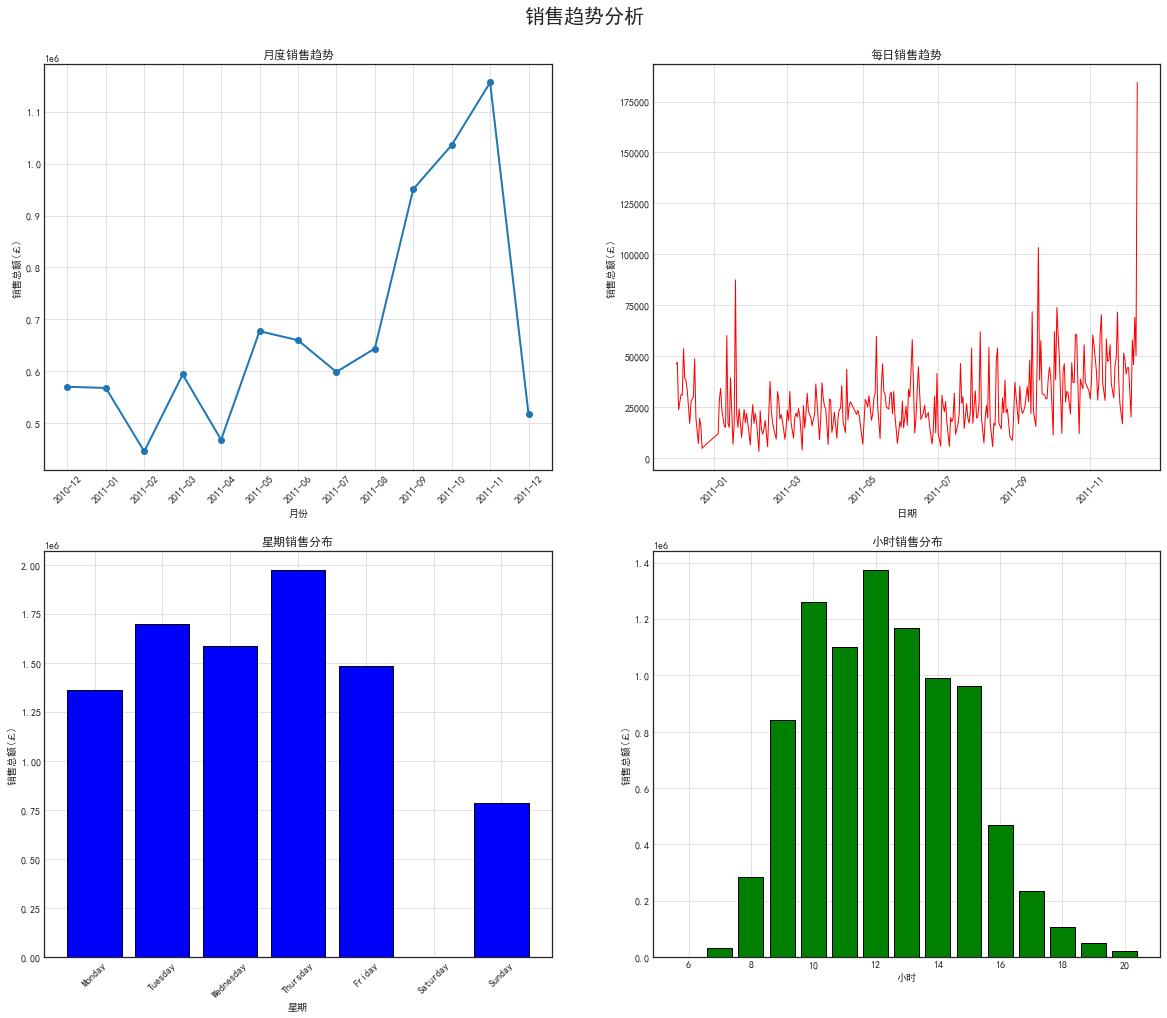

In [26]:
fig,axes = plt.subplots(2,2,figsize=(20,16))
fig.suptitle('销售趋势分析',fontsize=20,fontweight='bold',y=0.95)

# 月度销售趋势
monthly_sales = df_clean.groupby('Month')['TotalAmount'].sum()
axes[0,0].plot(monthly_sales.index.astype(str).to_numpy(),monthly_sales.values,marker='o',linewidth=2,markersize=6)
axes[0,0].set_title('月度销售趋势',fontweight='bold')
axes[0,0].set_xlabel('月份')
axes[0,0].set_ylabel('销售总额(￡)')
axes[0,0].tick_params(axis='x',rotation=45)
axes[0,0].grid(True,alpha=0.7)

# 每日销售趋势
daily_sales = df_clean.groupby(df_clean['InvoiceDate'].dt.date)['TotalAmount'].sum()
axes[0,1].plot(daily_sales.index.to_numpy(),daily_sales.values,color='red',linewidth=1)
axes[0,1].set_title('每日销售趋势',fontweight='bold')
axes[0,1].set_xlabel('日期')
axes[0,1].set_ylabel('销售总额(￡)')
axes[0,1].tick_params(axis='x',rotation=45)
axes[0,1].grid(True,alpha=0.7)

# 星期销售趋势
weekday_sales = df_clean.groupby('Day')['TotalAmount'].sum()
weekday_order = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
weekday_sales = weekday_sales.reindex(weekday_order)
axes[1,0].bar(weekday_sales.index.to_numpy(),weekday_sales.values,color='blue',edgecolor='black')
axes[1,0].set_title('星期销售分布',fontweight='bold')
axes[1,0].set_xlabel('星期')
axes[1,0].set_ylabel('销售总额(￡)')
axes[1,0].tick_params(axis='x',rotation=45)
axes[1,0].grid(True,alpha=0.7)

# 小时销售趋势
hourly_sales = df_clean.groupby('Hour')['TotalAmount'].sum()
axes[1,1].bar(hourly_sales.index.to_numpy(),hourly_sales.values,color='green',edgecolor='black')
axes[1,1].set_title('小时销售分布',fontweight='bold')
axes[1,1].set_xlabel('小时')
axes[1,1].set_ylabel('销售总额(￡)')
axes[1,1].tick_params(axis='x')
axes[1,1].grid(True,alpha=0.7)

plt.subplots_adjust(top=0.9)
plt.show()

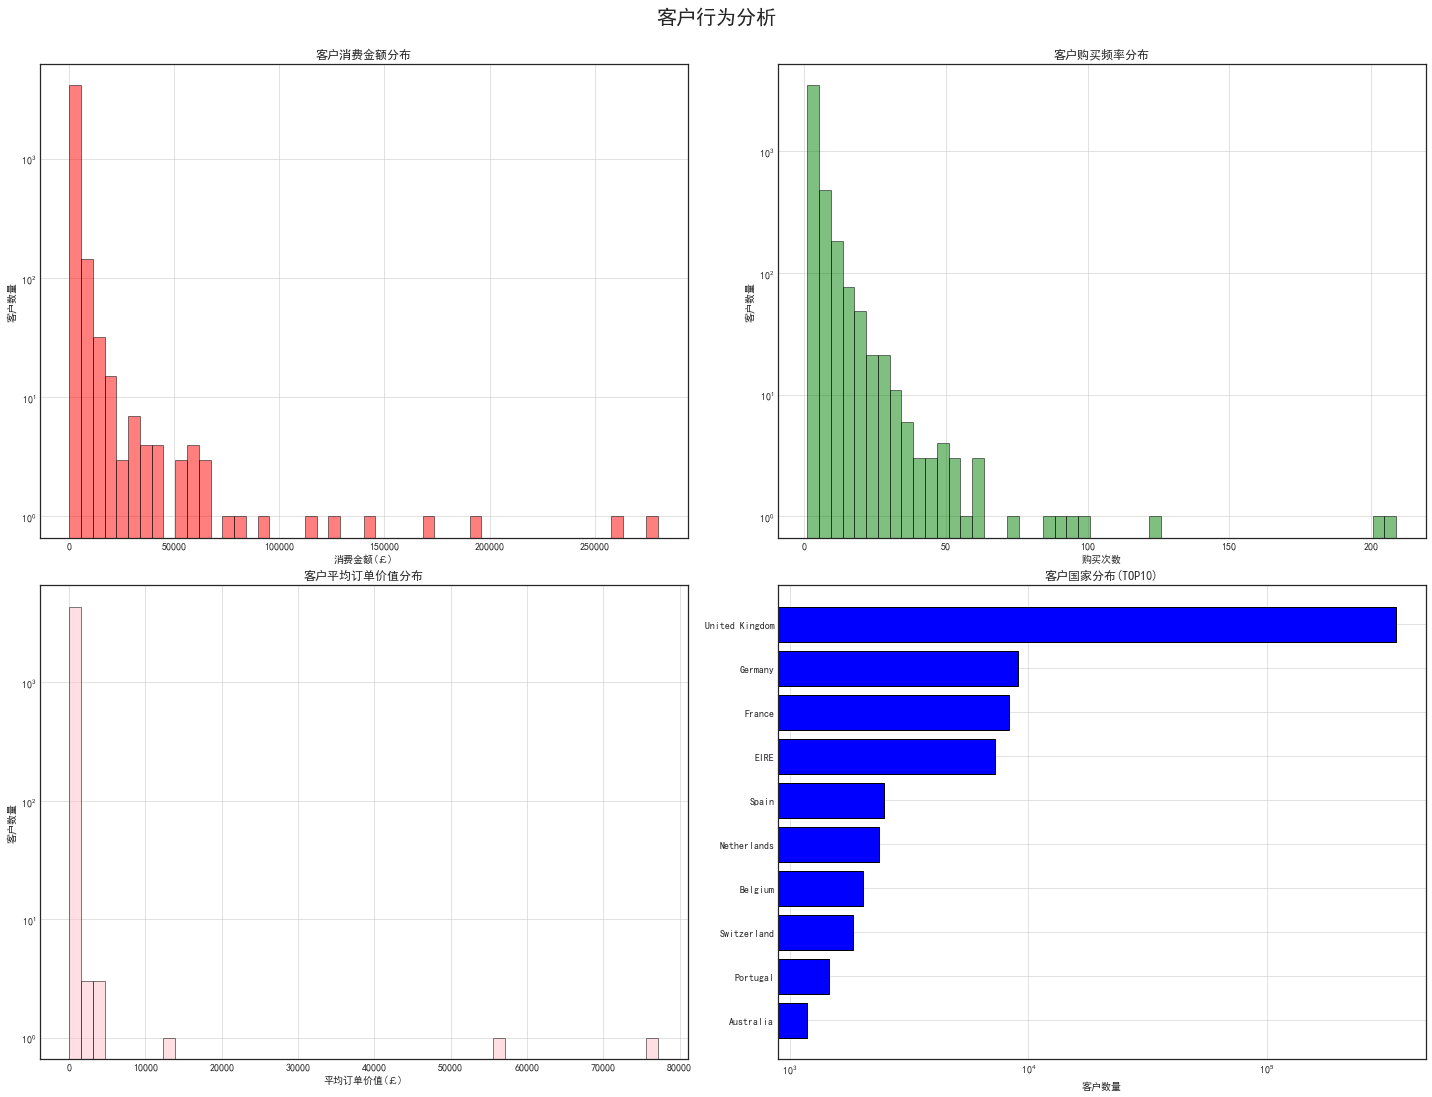

In [43]:
fig,axes = plt.subplots(2,2,figsize=(20,16))
fig.suptitle('客户行为分析',fontsize=20,fontweight='bold',y=0.95)

# 客户消费金额分布
customer_spending = df_clean.groupby('Customer ID')['TotalAmount'].sum()
axes[0,0].hist(customer_spending,bins=50,edgecolor='black',alpha=0.5,color='red')
axes[0,0].set_title('客户消费金额分布',fontweight='bold')
axes[0,0].set_xlabel('消费金额(￡)')
axes[0,0].set_ylabel('客户数量')
axes[0,0].set_yscale('log')
axes[0,0].grid(True,alpha=0.7)

# 客户购买频率分布
customer_frequency = df_clean.groupby('Customer ID')['Invoice'].nunique()
axes[0,1].hist(customer_frequency,bins=50,edgecolor='black',alpha=0.5,color='green')
axes[0,1].set_title('客户购买频率分布',fontweight='bold')
axes[0,1].set_xlabel('购买次数')
axes[0,1].set_ylabel('客户数量')
axes[0,1].set_yscale('log')
axes[0,1].grid(True,alpha=0.7)

# 客户平均订单价值
customer_avg_order = df_clean.groupby('Customer ID')['TotalAmount'].mean()
axes[1,0].hist(customer_avg_order,bins=50,edgecolor='black',alpha=0.5,color='pink')
axes[1,0].set_title('客户平均订单价值分布',fontweight='bold')
axes[1,0].set_xlabel('平均订单价值(￡)')
axes[1,0].set_ylabel('客户数量')
axes[1,0].set_yscale('log')
axes[1,0].grid(True,alpha=0.7)

# 客户地理分布(按国家)
country_distribution = df_clean['Country'].value_counts().head(10)
axes[1,1].barh(country_distribution.index,country_distribution.values,color='blue',edgecolor='black')
axes[1,1].set_title('客户国家分布(TOP10)',fontweight='bold')
axes[1,1].set_xlabel('客户数量')
axes[1,1].set_xscale('log')
axes[1,1].grid(True,alpha=0.7)
axes[1,1].invert_yaxis()

plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()

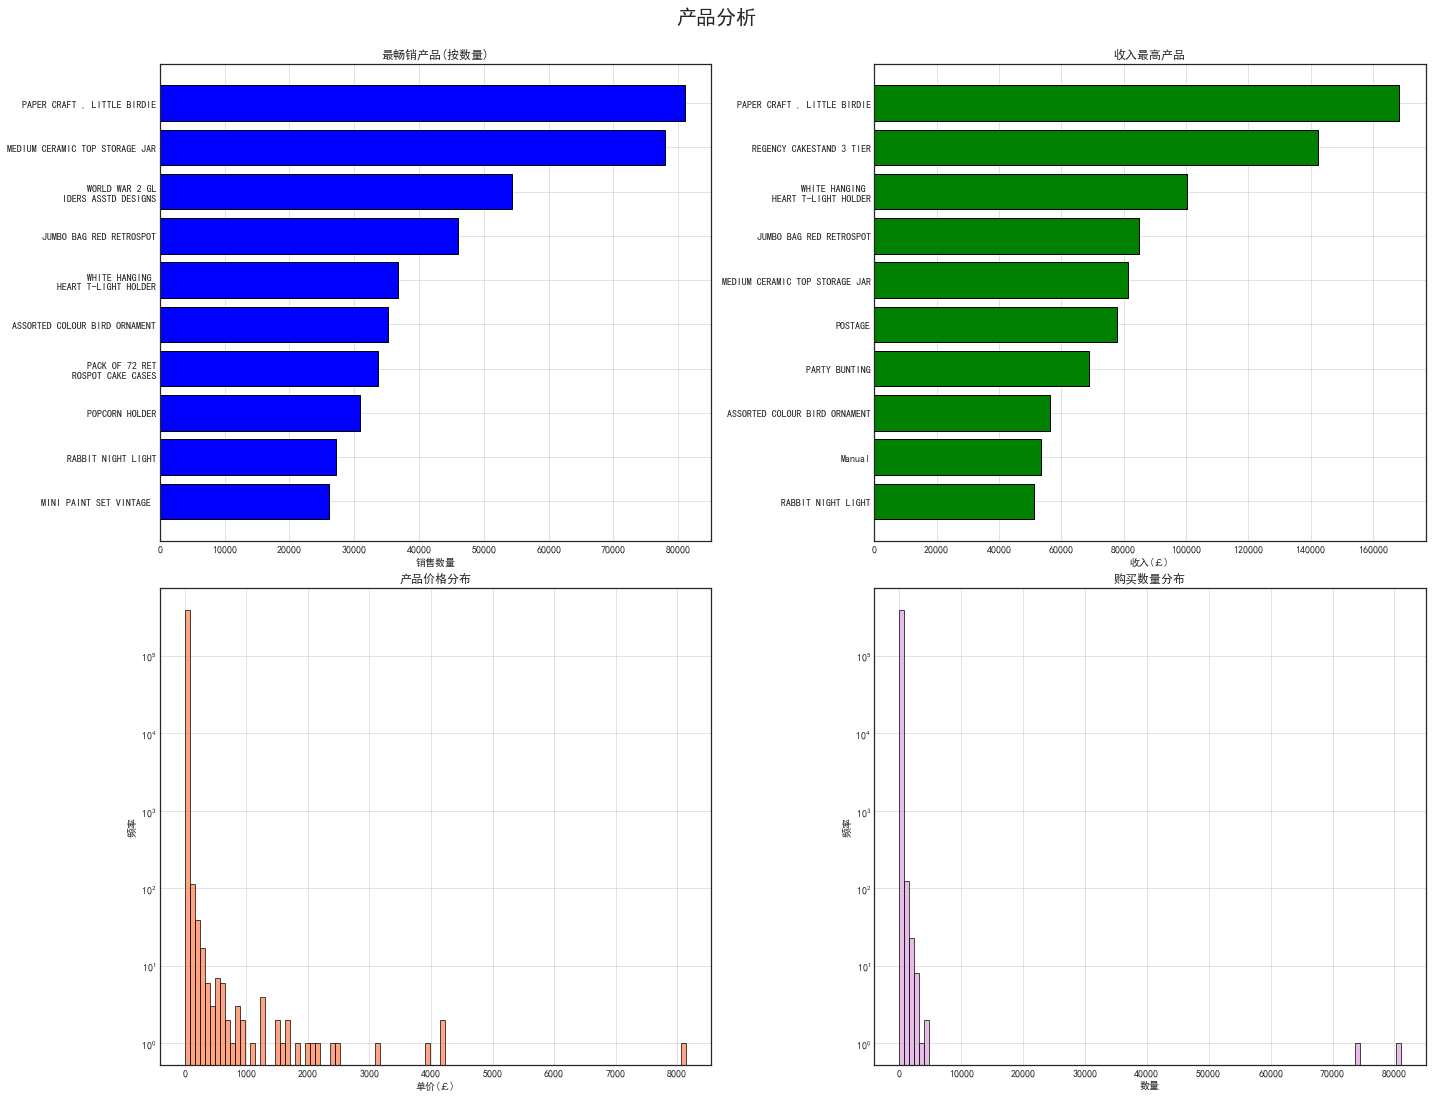

In [28]:
fig,axes = plt.subplots(2,2,figsize=(20,16))
fig.suptitle('产品分析',fontsize=20,fontweight='bold',y=0.95)

# 最畅销产品
top_products = df_clean.groupby('Description')['Quantity'].sum().sort_values(ascending=False).head(10)
axes[0,0].barh(range(len(top_products)),top_products.values,color = 'blue',edgecolor='black')
axes[0,0].set_yticks(range(len(top_products)))
axes[0,0].set_yticklabels([label[:14] + '\n' + label[14:] if len(label) > 30 else label for label in top_products.index])
axes[0,0].set_title('最畅销产品(按数量)',fontweight='bold')
axes[0,0].set_xlabel('销售数量')
axes[0,0].grid(True,alpha=0.7)
axes[0,0].invert_yaxis()

# 收入最高产品
top_revenue_products = df_clean.groupby('Description')['TotalAmount'].sum().sort_values(ascending=False).head(10)
axes[0,1].barh(range(len(top_revenue_products)),top_revenue_products.values,color = 'green',edgecolor='black')
axes[0,1].set_yticks(range(len(top_revenue_products)))
axes[0,1].set_yticklabels([label[:14] + '\n' + label[14:] if len(label) > 30 else label for label in top_revenue_products.index])
axes[0,1].set_title('收入最高产品',fontweight='bold')
axes[0,1].set_xlabel('收入(￡)')
axes[0,1].grid(True,alpha=0.7)
axes[0,1].invert_yaxis()

# 价格分布
axes[1,0].hist(df_clean['Price'],bins=100,edgecolor='black',alpha=0.7,color='coral')
axes[1,0].set_title('产品价格分布',fontweight='bold')
axes[1,0].set_xlabel('单价(￡)')
axes[1,0].set_ylabel('频率')
axes[1,0].set_yscale('log')
axes[1,0].grid(True,alpha=0.7)

# 数量分布
axes[1,1].hist(df_clean['Quantity'],bins=100,edgecolor='black',alpha=0.7,color='plum')
axes[1,1].set_title('购买数量分布',fontweight='bold')
axes[1,1].set_xlabel('数量')
axes[1,1].set_ylabel('频率')
axes[1,1].set_yscale('log')
axes[1,1].grid(True,alpha=0.7)

plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()

In [29]:
print('进行RFM用户细分分析')

# 设置分析基准日期(数据集最后一天的后一天)
analysis_date = df_clean['InvoiceDate'].max() + timedelta(days=1)

# 计算RFM指标
rfm = df_clean.groupby('Customer ID').agg({
    'InvoiceDate':lambda x:(analysis_date - x.max()).days
    ,'Invoice':'nunique'
    ,'TotalAmount':'sum'
}).reset_index()

rfm.columns = ['Customer ID','Recency','Frequency','Monetary']

print('RFM指标基本统计:')
display(rfm[['Recency','Frequency','Monetary']].describe())

# RFM评分
rfm['R_Score'] = pd.qcut(rfm['Recency'],4,labels=[4,3,2,1],duplicates='drop')
rfm['F_Score'] = pd.qcut(rfm['Frequency'],4,labels=[4,3,2],duplicates='drop')
rfm['M_Score'] = pd.qcut(rfm['Monetary'],4,labels=[4,3,2,1],duplicates='drop')

rfm['RFM_Score'] = rfm['R_Score'].astype(str) + rfm['F_Score'].astype(str) + rfm['M_Score'].astype(str)

# RFM客户细分
rfm['Segment'] = rfm.apply(
    lambda x:'冠军客户' if x['R_Score'] >= 4 and x['F_Score'] >= 4 and x['M_Score'] >= 4
    else '忠实客户' if x['R_Score'] >= 3 and x['F_Score'] >= 3 and x['M_Score'] >= 3
    else '潜力客户' if x['R_Score'] >= 2
    else '需要关注用户',
    axis = 1
)

print('RFM分析完毕')
print(f'\n客户细分统计:')
segment_counts = rfm['Segment'].value_counts()
print(segment_counts)

进行RFM用户细分分析
RFM指标基本统计:


,Recency,Frequency,Monetary
count,4338.000000,4338.000000,4338.000000
mean,92.536422,4.272015,2048.692230
std,100.014169,7.697998,8985.229676
min,1.000000,1.000000,3.750000
25%,18.000000,1.000000,306.482500
50%,51.000000,2.000000,668.570000
75%,142.000000,5.000000,1660.597500
max,374.000000,209.000000,280206.020000


RFM分析完毕

客户细分统计:
Segment
潜力客户      2524
需要关注用户    1084
忠实客户       629
冠军客户       101
Name: count, dtype: int64


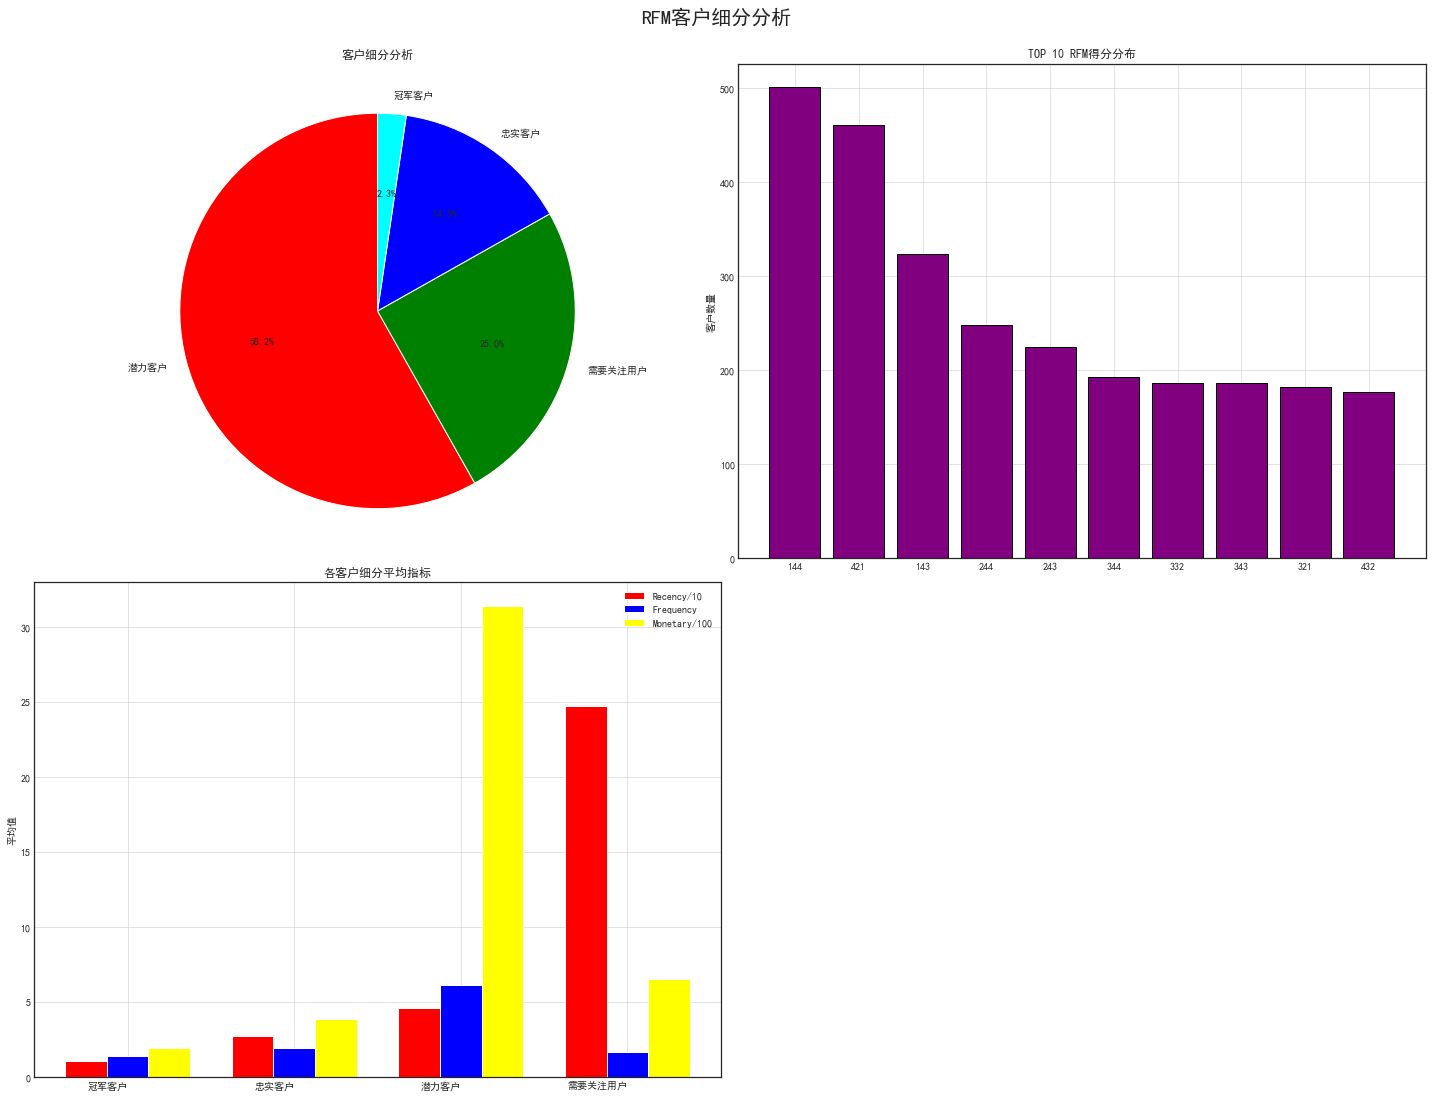

In [30]:
fig,axes = plt.subplots(2,2,figsize=(20,16))
fig.suptitle('RFM客户细分分析',fontsize=20,fontweight='bold',y=0.95)

# 客户细分分布
colors = ['red','green','blue','cyan','magenta']
axes[0,0].pie(segment_counts.values,labels=segment_counts.index,autopct='%1.1f%%',colors=colors,startangle=90)
axes[0,0].set_title('客户细分分析',fontweight='bold')

# RFM得分分布
rfm_score_counts = rfm['RFM_Score'].value_counts().head(10)
axes[0,1].bar(range(len(rfm_score_counts)),rfm_score_counts.values,color = 'purple',edgecolor='black')
axes[0,1].set_xticks(range(len(rfm_score_counts)))
axes[0,1].set_xticklabels(rfm_score_counts.index)
axes[0,1].set_title('TOP 10 RFM得分分布',fontweight='bold')
axes[0,1].set_ylabel('客户数量')
axes[0,1].grid(True,alpha=0.7)

# 各细分客户的平均指标
segment_metrics = rfm.groupby('Segment')[['Recency','Frequency','Monetary']].mean()
segment_metrics['Monetary'] = segment_metrics['Monetary'] / 100
segment_metrics['Recency'] = segment_metrics['Recency'] / 10
segments = segment_metrics.index
metrics = segment_metrics.columns
colors = ['red','blue','yellow']

bar_width = 0.25
for i,metric in enumerate(metrics):
    if metric == 'Monetary':
        legend_label = 'Monetary/100'
    elif metric == 'Recency':
        legend_label = 'Recency/10'
    else:
        legend_label = metric
    axes[1,0].bar(
        [x + i * bar_width for x in range(len(segments))],
        segment_metrics[metric],
        width=bar_width,
        label=legend_label,
        color=colors[i]
    )
axes[1,0].set_xticks([x + bar_width for x in range(len(segments))])
axes[1,0].set_xticklabels(segments,ha='right')

axes[1,0].set_title('各客户细分平均指标',fontweight='bold')
axes[1,0].set_ylabel('平均值')
axes[1,0].legend()
axes[1,0].grid(True,alpha=0.7)

axes.flat[3].remove()
plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()

进行购物篮分析
平均购物篮大小:278.01件产品
平均购物篮价值:￡479.56


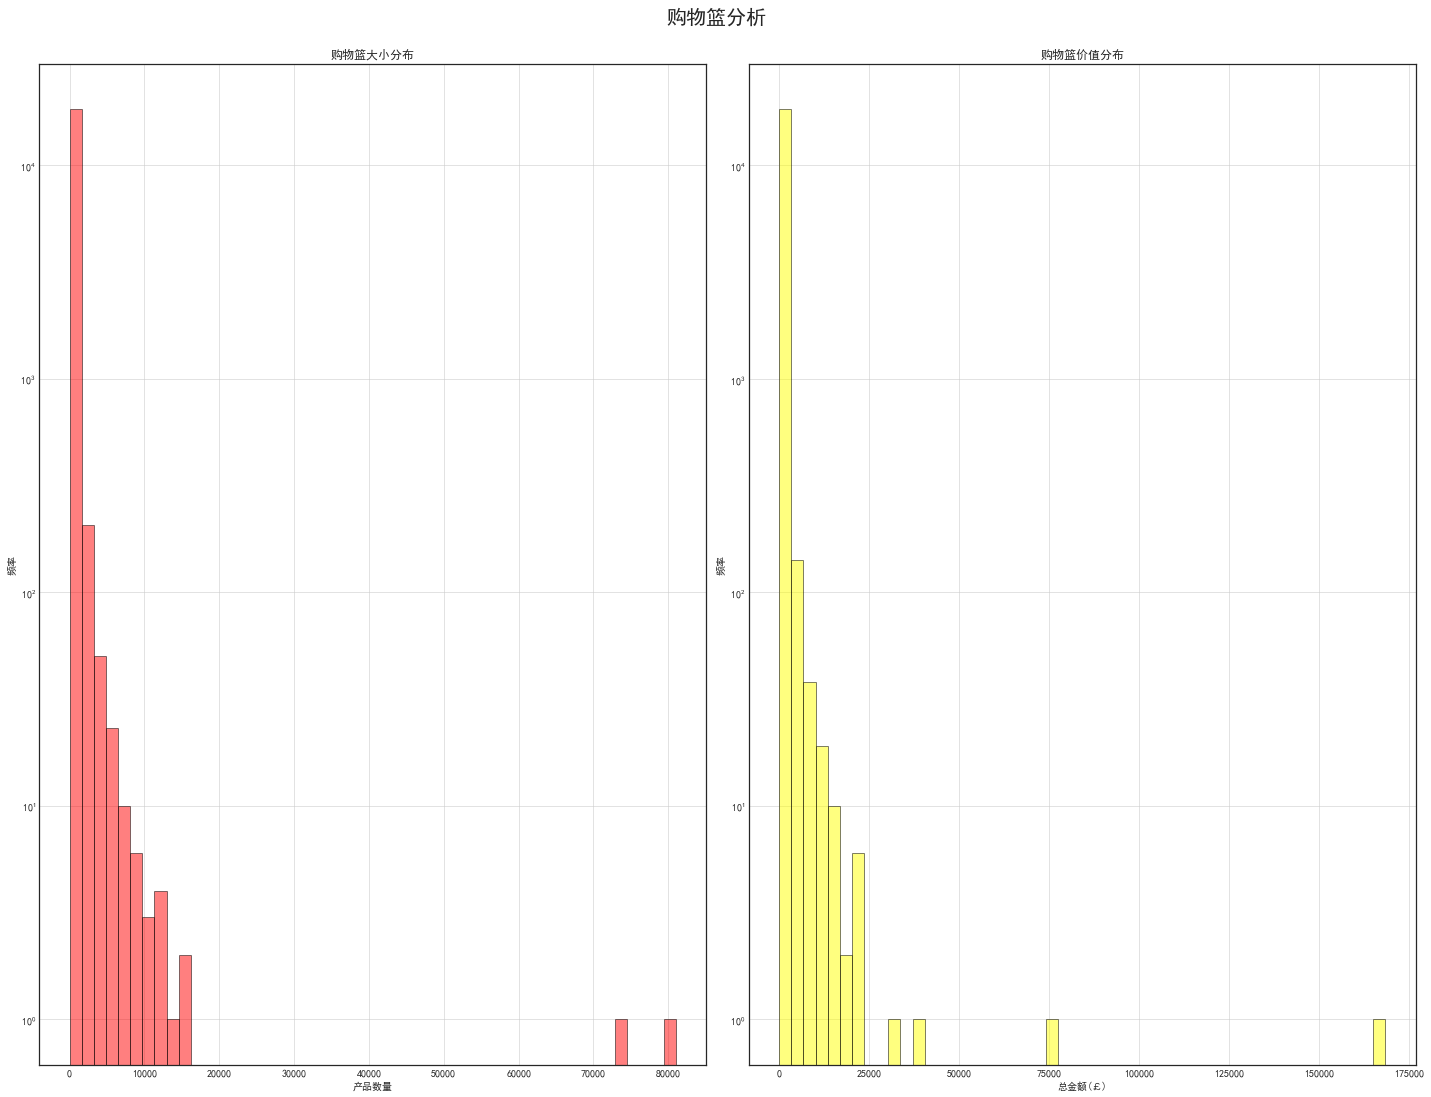

In [31]:
print('进行购物篮分析')

# 计算每张发票的产品数量
basket_size = df_clean.groupby('Invoice')['Quantity'].sum()
avg_basket_size = basket_size.mean()

# 计算每张发票的总金额
basket_value = df_clean.groupby('Invoice')['TotalAmount'].sum()
avg_basket_value = basket_value.mean()

print(f'平均购物篮大小:{avg_basket_size:.2f}件产品')
print(f'平均购物篮价值:￡{avg_basket_value:.2f}')

# 可视化购物篮分析
fig,axes = plt.subplots(1,2,figsize=(20,16))
fig.suptitle('购物篮分析',fontsize=20,fontweight='bold',y=0.95)

# 购物篮大小分布
axes[0].hist(basket_size,bins=50,edgecolor='black',color='red',alpha=0.5)
axes[0].set_yscale('log')
axes[0].set_title('购物篮大小分布',fontweight='bold')
axes[0].set_xlabel('产品数量')
axes[0].set_ylabel('频率')
axes[0].grid(True,alpha=0.7)

# 购物篮价值分布
axes[1].hist(basket_value,bins=50,edgecolor='black',color='yellow',alpha=0.5)
axes[1].set_yscale('log')
axes[1].set_title('购物篮价值分布',fontweight='bold')
axes[1].set_xlabel('总金额(￡)')
axes[1].set_ylabel('频率')
axes[1].grid(True,alpha=0.7)

plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()

In [32]:
print('准备机器学习数据')

# 创建客户级别的特征
customer_features = df_clean.groupby('Customer ID').agg({
                                                        'Invoice':'nunique'
                                                        ,'TotalAmount':['sum','mean']
                                                        ,'Quantity':['sum','mean']
                                                        ,'InvoiceDate':['min','max','count']
                                                        ,'StockCode':'nunique'
                                                        ,'Country':'first'
                                                        }).reset_index()

customer_features.columns = ['Customer ID','Frequency','TotalSpent','AvgOrderValue','TotalQuantity','AvgQuantity','FirstPurchase','LastPurchase','TotalTransactions','UniqueProducts','Country']

# 计算客户活跃天数
customer_features['CustomerLifetime'] = (customer_features['LastPurchase'] - customer_features['FirstPurchase']).dt.days

# 创建目标变量:客户是否会再次购买(基于最后30天是否有购买)
cutoff_date = analysis_date - timedelta(days=30)
customer_features['WillPurchaseAgain'] = (customer_features['LastPurchase'] > cutoff_date).astype(int)

print(f'目标变量分析:')
target_distribution = customer_features['WillPurchaseAgain'].value_counts()
print(target_distribution)
print(f"正样本比例:{customer_features['WillPurchaseAgain'].mean():.2f}")

准备机器学习数据
目标变量分析:
WillPurchaseAgain
0    2731
1    1607
Name: count, dtype: int64
正样本比例:0.37


In [33]:
# 特征工程
ml_data = customer_features.copy()

# 选择数值特征
numeric_features = ['Frequency','TotalSpent','AvgOrderValue','TotalQuantity','AvgQuantity','TotalTransactions','UniqueProducts','CustomerLifetime']

# 处理分类变量(国家)
country_encoder = LabelEncoder()
ml_data['Country_encoded'] = country_encoder.fit_transform(ml_data['Country'])

# 准备特征和目标变量
X = ml_data[numeric_features + ['Country_encoded']]
y = ml_data['WillPurchaseAgain']

# 数据标准化
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 分割数据集
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y,test_size = 0.3, random_state = 42,stratify=y)

print(f'训练集大小:{X_scaled.shape}')
print(f'测试集大小:{X_test.shape}')

# 显示特征名称
feature_names = numeric_features + ['Country_encoded']
print(f'\n使用的特征:{feature_names}')

训练集大小:(4338, 9)
测试集大小:(1302, 9)

使用的特征:['Frequency', 'TotalSpent', 'AvgOrderValue', 'TotalQuantity', 'AvgQuantity', 'TotalTransactions', 'UniqueProducts', 'CustomerLifetime', 'Country_encoded']


In [34]:
print('训练随机森林分类器')
rf_model = RandomForestClassifier(n_estimators=50,max_depth=5,random_state=42,class_weight='balanced')
rf_model.fit(X_train,y_train)

# 预测
y_pred = rf_model.predict(X_test)
y_pred_proba = rf_model.predict_proba(X_test)[:,1]

# 模型评估
print('\n模型性能评估:')
print(classification_report(y_test, y_pred))

# 计算AUC-ROC
auc_roc = roc_auc_score(y_test, y_pred_proba)
print(f'AUC-ROC Score:{auc_roc:.4f}')

# 特征重要性
feature_importance = pd.DataFrame({'feature':feature_names,'importance':rf_model.feature_importances_}).sort_values('importance',ascending=False)

print('\n特征重要性:')
display(feature_importance)

# 交叉验证
cv_scores = cross_val_score(rf_model,X_train,y_train,cv=10,scoring='roc_auc')
print('5 折交叉验证AUC-ROC均值:',cv_scores.mean())

训练随机森林分类器

模型性能评估:
              precision    recall  f1-score   support

           0       0.80      0.76      0.78       820
           1       0.62      0.67      0.64       482

    accuracy                           0.72      1302
   macro avg       0.71      0.71      0.71      1302
weighted avg       0.73      0.72      0.73      1302

AUC-ROC Score:0.8055

特征重要性:


,feature,importance
7,CustomerLifetime,0.422623
0,Frequency,0.199977
5,TotalTransactions,0.099909
1,TotalSpent,0.083788
3,TotalQuantity,0.069290
6,UniqueProducts,0.054792
2,AvgOrderValue,0.032244
4,AvgQuantity,0.031589
8,Country_encoded,0.005788


5 折交叉验证AUC-ROC均值: 0.7908109352005989


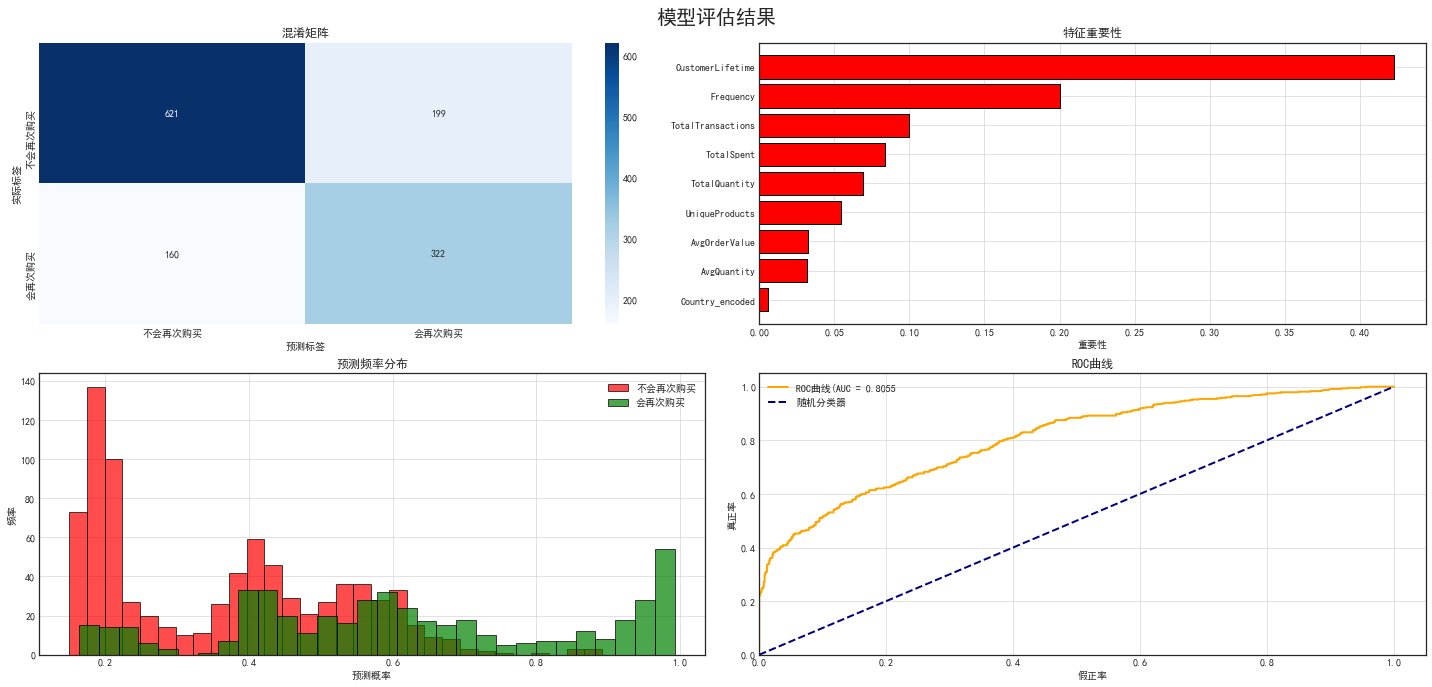

In [35]:
fig,axes = plt.subplots(2,2,figsize=(20,10))
fig.suptitle('模型评估结果',fontsize=20,fontweight='bold',y=0.95)

# 混淆矩阵
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm,annot=True,fmt='d',cmap='Blues',ax=axes[0,0],xticklabels=['不会再次购买','会再次购买'],yticklabels=['不会再次购买','会再次购买'])
axes[0,0].set_title('混淆矩阵',fontweight='bold')
axes[0,0].set_xlabel('预测标签')
axes[0,0].set_ylabel('实际标签')

# 预测概率分布
axes[0,1].barh(feature_importance['feature'],feature_importance['importance'],color='red',edgecolor='black')
axes[0,1].set_title('特征重要性',fontweight='bold')
axes[0,1].set_xlabel('重要性')
axes[0,1].invert_yaxis()
axes[0,1].grid(True,alpha=0.7)

# 预测概率分布
axes[1,0].hist(y_pred_proba[y_test == 0],bins=30,alpha=0.7,label='不会再次购买',color='red',edgecolor='black')
axes[1,0].hist(y_pred_proba[y_test == 1],bins=30,alpha=0.7,label='会再次购买',color='green',edgecolor='black')
axes[1,0].set_title('预测频率分布',fontweight='bold')
axes[1,0].set_xlabel('预测概率')
axes[1,0].set_ylabel('频率')
axes[1,0].legend()
axes[1,0].grid(True,alpha=0.7)

# ROC曲线
fpr,tpr,thresholds = roc_curve(y_test,y_pred_proba)
axes[1,1].plot(fpr,tpr,color='orange',lw=2,label=f'ROC曲线(AUC = {auc_roc:.4f}')
axes[1,1].plot([0,1],[0,1],color='navy',lw=2,linestyle='--',label='随机分类器')
axes[1,1].set_xlim([0.0,1.05])
axes[1,1].set_ylim([0.0,1.05])
axes[1,1].set_xlabel('假正率')
axes[1,1].set_ylabel('真正率')
axes[1,1].set_title('ROC曲线',fontweight='bold')
axes[1,1].legend(loc='higher right')
axes[1,1].grid(True,alpha=0.7)

plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()

In [36]:
print('关键业务总结:')
print('='*50)

total_revenue = df_clean['TotalAmount'].sum()
avg_order_value = df_clean.groupby('Invoice')['TotalAmount'].sum().mean()
unique_customers = df_clean['Customer ID'].nunique()
repeat_customers = df_clean.groupby('Customer ID')['Invoice'].nunique()
repeat_rate = (repeat_customers > 1).mean()

# 计算月均增长率
monthly_revenue = df_clean.groupby('Month')['TotalAmount'].sum()
if len(monthly_revenue) > 2:
    growth_rates = monthly_revenue.pct_change().dropna()
    avg_monthly_growth = growth_rates.mean()
else:
    avg_monthly_growth = 0

print(f'总营收:￡{total_revenue:.2f}')
print(f'平均订单价值:￡{avg_order_value:.2f}')
print(f'独特客户数量:{unique_customers:,}')
print(f'客户复购率:{repeat_rate:.2%}')
print(f'最畅销产品:{top_products.index[0]}(售出{top_products.iloc[0]:,}件)')
print(f'收入最高产品:{top_revenue_products.index[0]}(收入￡{top_revenue_products.iloc[0]:,})')
if avg_monthly_growth != 0:
    print(f'月均增长率:{avg_monthly_growth:.2%}')

#RFM细分统计
champion_customers = segment_counts.get('冠军客户',0)
loyal_customers = segment_counts.get('忠实客户',0)
print(f'\n高价值客户分析:')
print(f'冠军客户数量:{champion_customers}({champion_customers/len(rfm)*100:.1f}%)')
print(f'忠实客户数量:{loyal_customers}({loyal_customers/len(rfm)*100:.1f}%)')

关键业务总结:
总营收:￡8887226.89
平均订单价值:￡479.56
独特客户数量:4,338
客户复购率:65.58%
最畅销产品:PAPER CRAFT , LITTLE BIRDIE(售出80,995件)
收入最高产品:PAPER CRAFT , LITTLE BIRDIE(收入￡168,469.6)
月均增长率:3.62%

高价值客户分析:
冠军客户数量:101(2.3%)
忠实客户数量:629(14.5%)


In [37]:
df_clean.to_csv('Online_Retail_Cleaned.csv',index=False)
rfm.to_csv('RFM_Analysis_Results.csv',index=False)
customer_features.to_csv('Customer_Features.csv',index=False)
X_test_df = pd.DataFrame(X_test,columns=feature_names)
result_df = X_test_df.copy()
result_df['Actual'] = y_test
result_df['Predicted'] = y_pred
result_df['Predicted_Probability'] = y_pred_proba
result_df.to_csv('rf_prediction_results.csv',index=False)

print('数据已保存为csv文件')
print('项目完成')

数据已保存为csv文件
项目完成
